Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.


MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.


## Data Description

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

Download Data:

https://drive.google.com/file/d/1KDQBTbo5deKGCdVV_xIujscn5ImxW4dm/view?usp=sharing

## Objective

Predict if the page is being flipped using a single image.

## Importing Librairies

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import plotly.express as px
from sklearn.metrics import roc_curve, auc
from tensorflow.keras import layers

## Creating the dataset

In [ ]:
# setting folder paths with training and testing images
train_dir = "drive/MyDrive/images/training"
test_dir = "drive/MyDrive/images/testing"

In [ ]:
# parameters for the loader 
batch_size=32
img_height = 180
img_width = 180

# creating the training and testing datasets
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=42, image_size=(img_height, img_width),
                                                      batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=42, image_size=(img_height, img_width), 
                                                     batch_size=batch_size)

Found 2401 files belonging to 2 classes.
Found 597 files belonging to 2 classes.


In [ ]:
# checking the classes of both train and test
print(train_ds.class_names)
print(test_ds.class_names)

['flip', 'notflip']
['flip', 'notflip']


# Visualize data

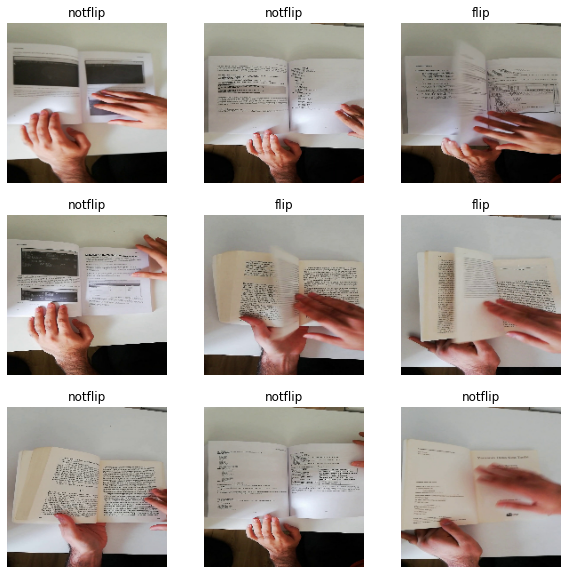

In [ ]:
# displaying the first 9 images in the train data
nb_images = 10
plt.figure(figsize=(nb_images,nb_images))
for images, labels in train_ds.take(1):
    for i in range(nb_images-1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

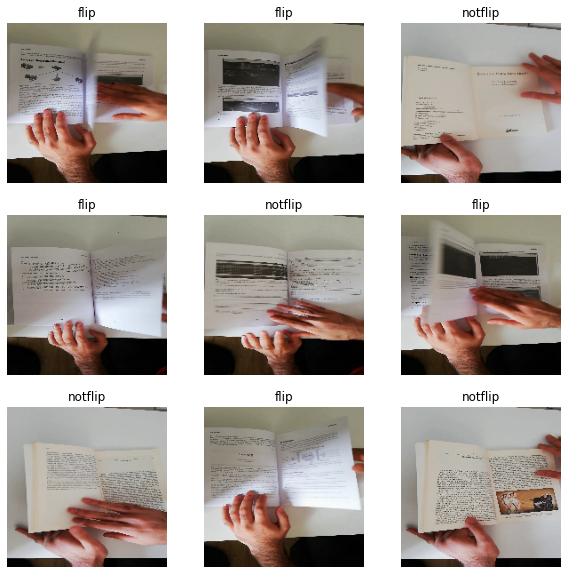

In [ ]:
# displaying the first 9 images in the test data
plt.figure(figsize=(nb_images,nb_images))
for images, labels in test_ds.take(1):
    for i in range(nb_images-1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(test_ds.class_names[labels[i]])
        plt.axis('off')

In [ ]:
# shape of train_ds: 32 images of size 180*180*3 with 1 label 0/1 for each image
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
# shape of test_ds: 32 images of size 180*180*3 with 1 label 0/1 for each image
for image_batch, labels_batch in test_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


## Data Preprocesssing

In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
Dataset.prefetch overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
DATASET_SIZE = len(train_ds)
train_size = int(0.8 * DATASET_SIZE)
train_ds_ = train_ds.take(train_size)
valid_ds = train_ds.skip(train_size)
train_ds = train_ds_

In [ ]:
# Create a data augmentation layer
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Create the model

In [ ]:
# creating a CNN model
model = tf.keras.Sequential([
    #data_augmentation,
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

# model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 64)       0

In [ ]:
# training the model
history = model.fit(train_ds,validation_data = valid_ds,epochs = 15)

Epoch 1/15
60/60 [==============================] - 42s 599ms/step - loss: 0.7243 - accuracy: 0.5786 - f1_m: 0.5082 - val_loss: 0.5941 - val_accuracy: 0.6902 - val_f1_m: 0.6820
Epoch 2/15
60/60 [==============================] - 2s 26ms/step - loss: 0.4394 - accuracy: 0.8047 - f1_m: 0.8156 - val_loss: 0.3183 - val_accuracy: 0.8690 - val_f1_m: 0.8151
Epoch 3/15
60/60 [==============================] - 1s 24ms/step - loss: 0.2037 - accuracy: 0.9245 - f1_m: 0.9252 - val_loss: 0.1657 - val_accuracy: 0.9376 - val_f1_m: 0.8806
Epoch 4/15
60/60 [==============================] - 2s 25ms/step - loss: 0.1362 - accuracy: 0.9495 - f1_m: 0.9491 - val_loss: 0.1374 - val_accuracy: 0.9459 - val_f1_m: 0.8863
Epoch 5/15
60/60 [==============================] - 2s 25ms/step - loss: 0.0691 - accuracy: 0.9776 - f1_m: 0.9776 - val_loss: 0.0597 - val_accuracy: 0.9896 - val_f1_m: 0.9280
Epoch 6/15
60/60 [==============================] - 1s 24ms/step - loss: 0.1120 - accuracy: 0.9568 - f1_m: 0.9564 - val_los

## Visualize results

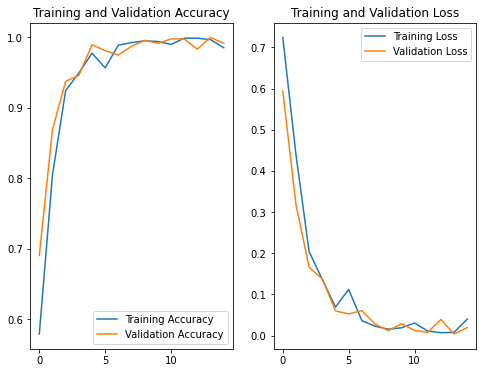

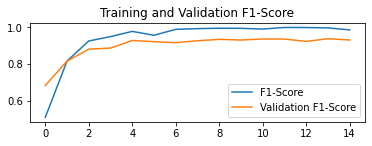

In [ ]:
# Create plots of the loss and accuracy on the training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']

epochs_range = range(15)

plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs_range, f1, label='F1-Score')
plt.plot(epochs_range, val_f1, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.title("Training and Validation F1-Score")
plt.show()

In [ ]:
test_label = np.concatenate([y for x, y in test_ds], axis=0)
pred_label = tf.round(model.predict(test_ds))

19/19 [==============================] - 0s 11ms/step


In [ ]:
def calculate_metrics(Y_test,Y_pred):
    cf_matrix = confusion_matrix(Y_test, Y_pred)
    
    true_pos = cf_matrix[1][1]
    false_pos = cf_matrix[0][1]
    false_neg = cf_matrix[1][0]
    true_neg = cf_matrix[0][0]
    
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    # True positive rate
    sensitivity = true_pos / (true_pos + false_neg)
    
    # True negative rate
    specificity = true_neg / (true_neg + false_pos)

    f1_score = 2*(precision*recall)/(precision+recall)
    
    result = "precision : " + str(round(precision,2)) + ", recall :" + str(round(recall,2)) + ", sensitivity: " + str(round(sensitivity,2)) + ", specificity: " + str(round(specificity,2)) + ", F1-score: " + str(round(f1_score,4))
    
    print(result)
    
    return

In [ ]:
def plot_confusion_matrix(test_label, pred_label):

  cf_matrix = confusion_matrix(test_label, pred_label)

  # Plot the confusion matrix
  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [ ]:
# ROC Curve is the plot of the sensitivity (TP rate) by the FP rate (1-specificity).

def plot_ROC_curve(Y_test,Y_pred):
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    # Best threshold (maximising the specificity and sensitivity).
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("The best threshold is :" + str(round(optimal_threshold,2)))

    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()

The ROC curve is a plot that shows the relation between the TPR(True positive rate) and FPR (False Positive rate) for different thresholds. In general, a model with a larger AUC (area under curve) is usually interpreted as performing better than a model with a smaller AUC. The AUC is extremely high for this model. All the metrics are very high which indicates that the model is performing well.

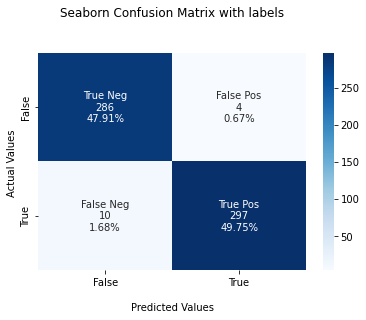

precision : 0.99, recall :0.97, sensitivity: 0.97, specificity: 0.99, F1-score: 0.977
The best threshold is :1.0


In [ ]:
plot_confusion_matrix(test_label, pred_label)
calculate_metrics(test_label, pred_label)
plot_ROC_curve(test_label,pred_label)

In [ ]:
# 1 image
predtest = tf.round(model.predict(test_ds))
total_number_images = len(predtest)
random_num = random.choice(range(total_number_images))
if predtest[random_num] == 1.0 and test_label[random_num] == 1.0:
  print("Image is flipped and correctly predicted as flipped.")

if predtest[random_num] == 1.0 and test_label[random_num] == 0.0:
  print("Image is not flipped and predicted as flipped.")

if predtest[random_num] == 0.0 and test_label[random_num] == 1.0:
  print("Image is flipped and predicted as not flipped.")

if predtest[random_num] == 0.0 and test_label[random_num] == 0.0:
  print("Image is not flipped and correctly predicted as flipped.")

19/19 [==============================] - 0s 11ms/step
Image is not flipped and correctly predicted as flipped.


## Bonus : Predict if a given sequence of images contains an action of flipping.


In [ ]:
# Sequence of n_images
# Add the comparison with the true value
n_images = 50
predtest = tf.round(model.predict(test_ds))
initial_position = random.choice(range(len(predtest)))
sequence_images_pred = predtest[initial_position: initial_position + n_images]
sequence_images_true = test_label[initial_position: initial_position + n_images]
sequence_flip = False
for i in sequence_images:
  if i == 1.0:
    sequence_flip = True
    break
print("There is at least 1 flipped image in the sequence ?",sequence_flip,".")

19/19 [==============================] - 0s 13ms/step
There is at least 1 flipped image in the sequence ? True .


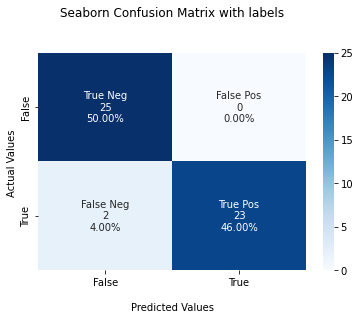

precision : 1.0, recall :0.92, sensitivity: 0.92, specificity: 1.0, F1-score: 0.9583
The best threshold is :1.0


In [ ]:
plot_confusion_matrix(sequence_images_true, sequence_images_pred)
calculate_metrics(sequence_images_true, sequence_images_pred)
plot_ROC_curve(sequence_images_true, sequence_images_pred)

## Conclusion

The company is developing MonReader which is a new mobile document digitalization experience. The proposed product is composed of a mobile app that allows the users to flip the pages. In that sense, the company propose computer vision solutions to detect if the image is flipped or not by an user.

In this project, our objective is to propose an algorithmic solution based on computer vision principles to predict if an image is indeed flipped or not. Because of the large number of images that we need to inspect, proposing an automated solution based on machine learning can reduce the time needed to analyze all of the training dataset, reduce human errors and obviously can be presented as an innovative solution and a service that can increase the ROI of the company by attracting investors that are interested in subscribing to the mobile app. This application can be used by many industries whenever they are dealing with images.

In the first part of the notebook, we pre-processed the datasset by normalizing the images, caching method that keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. We also make use of the prefetching method that overlaps data preprocessing and model execution while training. As a second step, we built a CNN model to predict if an image is flipped or not. The CNN model is based on a serie of 3 convolutional layers and max pooling layers. We then flatten the layers and use 2 Dense layers, when the last one is used for binary predicition. After this step, we trained our model on the training sample and used the accurarcy and the F1-score as evaluation metrics. The validation set is used to validate the model and see if there is some overfitting/underfitting when predicting on unseen data. The CNN based model is performing well with an accuracy of 99% on the test dataset and high F1-score of 99%. Based on the confusion matrix, we observe that the TP and TN represents 97.65% of the test data which is good. We also observed that the AUC of the model is extremely high (0.98) which is close to 1, and indicating that the model is performing well. The training and validation loss is decreasing during the 15 epochs and the model is not overfitting because there is no important fluctation of the validation loss at the final epochs. Our model can help the company in detecting if an image is flipped or not with high accuracy.

As a final step, we wanted to predict if a sequence of images contains an action of flipping. In order to proceed with this problem, we selected a serie of random images from the training dataset. The sequence of images is considered as "flipped" if at least one image in the serie is containing a flipped image. The confusion matrix and the ROC curve (AUC score) for this problem is very sensitive to the number of images that we need to take in our sequence. If this number is low, the information contained in the confusion matrix and the ROC curve cannot be considered as reliable. In the other side, having a large number of images to consider in our sequence allows us to affirm that the given results in the confusion matrix and the ROC curve are robust and reliable.

In this project, we have considered a simple CNN model which in this case performs well. However, we can also use more advanced and sophisticated computer vision algorithms to predict if an image is flipped or not. As an improvement it's also possible to use more hyperparameters such as the number of epochs, the optimizer used to estimate and update the weights in the CNN model. Because CNNs models are more reliable when the number of images is important, an improvement of our framework can be to export images from other sources and add it to the training dataset. 

